# Matrix Formalism

In this example we will consider the matrix formalism approach for a geometry of cylinders.

In [1]:
using SpinDoctor
using LinearAlgebra

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

setup = CylinderSetup(;
    name = "Slice",
    ncell = 3,
    rmin = 2.0,
    rmax = 6.0,
    dmin = 0.2,
    dmax = 0.3,
    height = 1.0,
    bend = 0.0,
    twist = 0.0,
    ecs_shape = :convex_hull,
    ecs_ratio = 0.5,
)

CylinderSetup{Float64}("Slice", "meshfiles", 3, 2.0, 6.0, 0.2, 0.3, 1.0, 0.0, 0.0, false, 0.5, :convex_hull, 0.5, Inf)

We also define coefficients for the different cell compartments `:in` (axon), `:out`
(myelin), and `:ecs` (ECS).

In [2]:
coeffs = coefficients(
    setup;
    D = (; in = 0.002 * I(3), out = 0.002 * I(3), ecs = 0.002 * I(3)),
    T₂ = (; in = Inf, out = Inf, ecs = Inf),
    ρ = (; in = 1.0, out = 1.0, ecs = 1.0),
    κ = (; in_out = 1e-4, out_ecs = 1e-4, in = 0.0, out = 0.0, ecs = 0.0),
    γ = 2.67513e-4,
)

(D = StaticArrays.SMatrix{3, 3, Float64, 9}[[0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002]], T₂ = [Inf, Inf, Inf, Inf], κ = [0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0], ρ = ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], γ = 0.000267513)

We then proceed to build the geometry and finite element mesh.

[ Info: Writing cell geometry to meshfiles/Slice_cells
[ Info: Saving mesh in Tetgen output format at meshfiles/Slice_dir/Slice_mesh.1


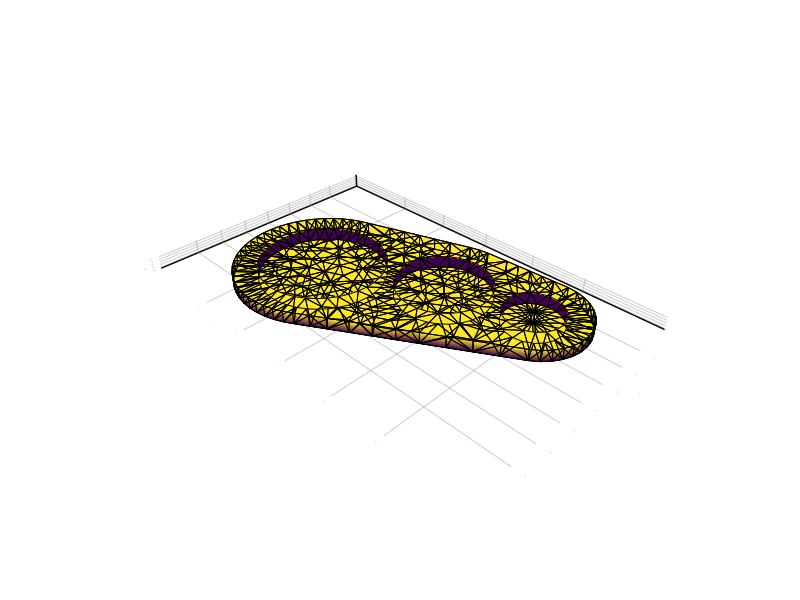

In [3]:
mesh, = create_geometry(setup; recreate = true)
plot_mesh(mesh)

The mesh looks good, so we may then proceed to assemble the biological model and the
associated finite element matrices.

In [4]:
model = Model(; mesh, coeffs...);
matrices = assemble_matrices(model);

We may also compute some useful quantities, including a scalar diffusion coefficient from
the diffusion tensors.

In [5]:
volumes = get_cmpt_volumes(model.mesh)
D_avg = 1 / 3 * tr.(model.D)' * volumes / sum(volumes)

0.0019999999999999996

The eigenfunctions of the diffusive part of the Bloch-Torrey operator forms a good basis
for the finite element function space. The basis may be truncated at a certain level, thus
reducing the number of degrees of freedom. We here opt for 400 eigenfunctions.

In [6]:
laplace = Laplace(; model, matrices, neig_max = 400)
lap_eig = solve(laplace)

┌ Info: Solving Laplace eigenvalue problem, computing 400 eigenvalues.
└ Problem size: 631 points.


(values = [5.087695957320292e-18, 1.4132199650866633e-5, 4.0509349069351374e-5, 6.39443720573399e-5, 7.441467207781295e-5, 8.949756938373927e-5, 0.00011736681610526925, 0.00012651456447040278, 0.00019262101580444494, 0.0002046377208765474  …  0.046545785156993105, 0.046596392042941887, 0.04673754480962611, 0.0469243107531081, 0.04705831596640958, 0.047165943787876356, 0.04744495469403004, 0.04748704984056109, 0.04775450686472779, 0.04794290487551416], funcs = [0.054186851628188246 0.03877004560472891 … -0.0008966272469835833 -5.460476296188972e-5; 0.05418685162818858 0.03993058606648592 … -0.002444712371412277 -0.0002704681850062134; … ; 0.05418685162818399 0.015301163339112427 … -0.015501459098936398 0.04207996011321985; 0.05418685162818401 0.025596508167335375 … 0.0013366437034588122 -0.007952198824746681], moments = [[-0.7468127781155055 -2.8423116076356205 … -0.0010985738436442244 -0.0011316623445776913; -2.8423116076356156 -1.1337429381482138 … 0.0012150428716078726 0.000241489709

The resulting eigenvalues may be represented as length scales, describing the wavelength
of the eigenfunctions.

In [7]:
length_scales = eig2length.(lap_eig.values, D_avg)

400-element Vector{Float64}:
  6.22879869839381e7
 37.37317447856927
 22.07431512899781
 17.569674150231794
 16.28679328926857
 14.851121466490234
 12.96857353298202
 12.49092521398258
 10.123088557758384
  9.821368934535482
  ⋮
  0.6508617135293538
  0.6498781316776602
  0.6485835349720063
  0.6476594099146938
  0.646920041879732
  0.6450150564500098
  0.6447291045606535
  0.6429211134569838
  0.6416566480703857

We may also further truncate the eigenfunction basis, if we are satisfied skipping
features below a threshold length scale of 3 micrometers.

In [8]:
length_scale = 3
λ_max = length2eig(length_scale, D_avg)
lap_eig = limit_lengthscale(lap_eig, λ_max)

(values = [5.087695957320292e-18, 1.4132199650866633e-5, 4.0509349069351374e-5, 6.39443720573399e-5, 7.441467207781295e-5, 8.949756938373927e-5, 0.00011736681610526925, 0.00012651456447040278, 0.00019262101580444494, 0.0002046377208765474  …  0.001401266581098797, 0.0014548840179905837, 0.0014554749817299285, 0.001471893866985435, 0.0014733360562846826, 0.0015683237437229905, 0.001698433474021388, 0.0018216696211608382, 0.0019422946683161394, 0.0021239103989344186], funcs = [0.054186851628188246 0.03877004560472891 … -0.00890729165831693 -0.006103786311247097; 0.05418685162818858 0.03993058606648592 … -0.008530010433599484 -0.0019113043779076585; … ; 0.05418685162818399 0.015301163339112427 … 0.08086406611826387 0.056369489001167374; 0.05418685162818401 0.025596508167335375 … 0.06887088361231593 0.06711490319381666], moments = [[-0.7468127781155055 -2.8423116076356205 … -0.0399158912598984 -0.11889599127633095; -2.8423116076356156 -1.1337429381482138 … -0.024877046794863196 -0.10659758

Each of the resulting eigenfunctions is represented in the same way as the initial
magnetization field `ρ`.

┌ Warning: Assignment to `nboundary` in soft scope is ambiguous because a global variable by the same name exists: `nboundary` will be treated as a new local. Disambiguate by using `local nboundary` to suppress this warning or `global nboundary` to assign to the existing global variable.
└ @ string:7


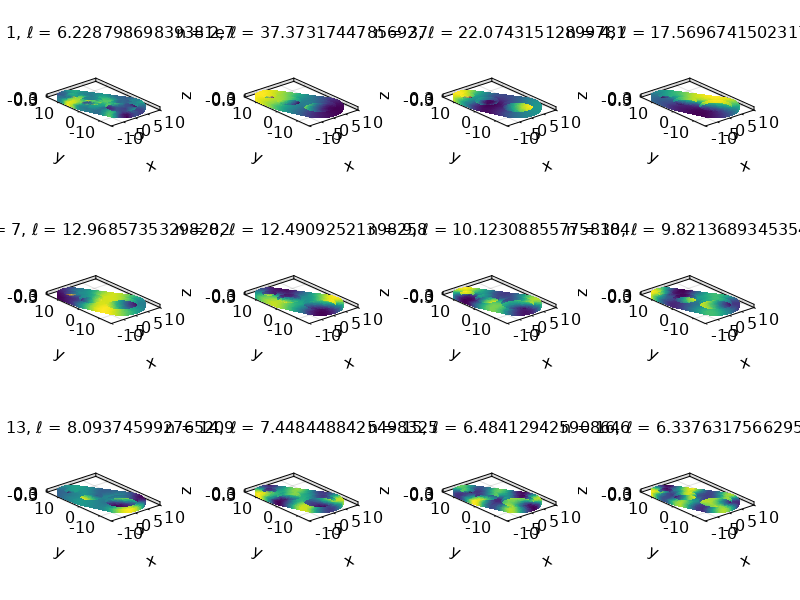

In [9]:
ncompartment, nboundary = size(mesh.facets)
fig = Figure()
for i = 1:3, j = 1:4
    ieig = 6(i - 1) + j
    ϕ_cmpts = split_field(mesh, lap_eig.funcs[:, ieig])
    ax = Axis3(fig[i, j]; title = "n = $ieig, ℓ = $(length_scales[ieig])", aspect = :data)
    nboundary = size(mesh.facets, 2)
    scene = nothing
    first = true
    for icmpt = 1:ncompartment, iboundary = 1:nboundary
        facets = mesh.facets[icmpt, iboundary]
        points = mesh.points[icmpt]
        mesh!(ax, points', facets', color = ϕ_cmpts[icmpt], shading = false)
    end
end
fig

We observe that the first functions have large features, while the higher-index functions
have more rapidly varying features. We may now choose a gradient and compute the
projection of magnetization field onto the truncated basis.

In [10]:
dir = [1.0, 0.0, 0.0]
profile = CosOGSE(5000.0, 5000.0, 2)
b = 1000
g = √(b / int_F²(profile)) / coeffs.γ
gradient = ScalarGradient(dir, profile, g)

The matrix formalism problem is solved in the same way as the `BTPDE`. The time
profile is approximated on 500 points, since it is non-constant.

In [11]:
mf = MatrixFormalism(; model, matrices, lap_eig)
ξ = solve(mf, gradient; ninterval = 500)

631-element Vector{ComplexF64}:
  0.2403763349479532 + 0.021234321804486075im
 0.23897880105519215 + 0.020976749261889586im
 0.23453439700185935 + 0.017849497435276498im
  0.2283242872046291 + 0.013111825060465139im
 0.22088199552543053 + 0.006625840537278753im
  0.2145372770515467 - 0.000638183591696466im
 0.20959377532063714 - 0.006011027638062231im
 0.20563445670371366 - 0.009389844149972683im
 0.20580271378620552 - 0.011454519244021874im
 0.21029449707734468 - 0.0131982627550878im
                     ⋮
  0.4052782508429062 + 0.007752946623321759im
  0.3703362900677824 + 0.012319212772870167im
   0.317776318106484 - 0.0001885039472736931im
  0.3046388218109929 + 0.033997041116510064im
  0.3416227664508621 + 0.005987277906760017im
  0.3104907260175299 - 0.008579899076119654im
  0.3475559796380352 + 0.012161047115775887im
 0.34393343839478147 + 0.011876501453985422im
  0.3433946147881733 + 0.010152798380632164im

The resulting magnetization field may be plotted.

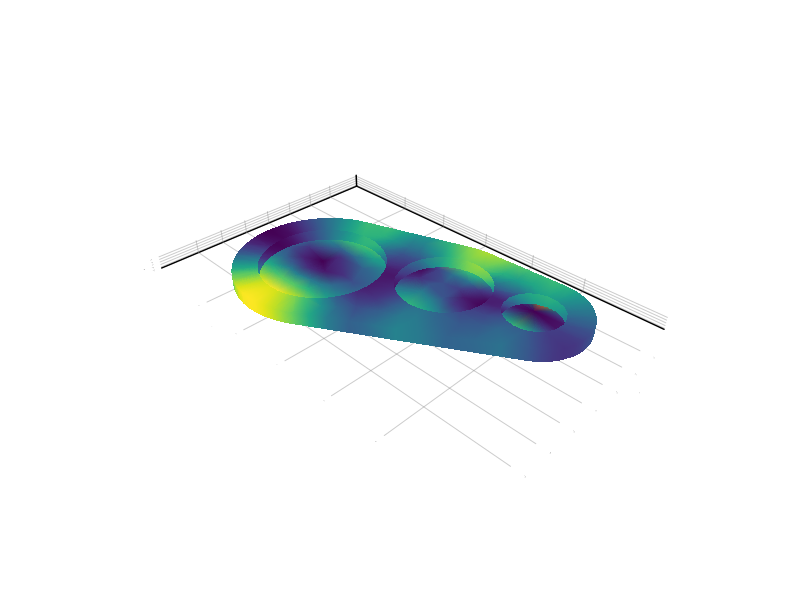

In [12]:
plot_field(model.mesh, ξ)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*